# Project 11.75: Recurrent Neural Networks (RNNs) from Scratch

## Goal
Build RNNs (vanilla RNN, LSTM) from NumPy alone to understand sequence modeling, then contrast with transformers to see why attention is superior.

## Learning Objectives
- Implement vanilla RNN and LSTM from scratch with backpropagation through time (BPTT)
- Train on character-level text (same Shakespeare data you'll use for transformer pretraining)
- Observe vanishing/exploding gradients and how LSTMs mitigate them
- Understand recurrence: stateful computation vs. transformer parallelism
- Compare sequence modeling capacity: RNN vs transformer on same task

## Why This Project
Before building transformers, you need to understand:
1. **The sequence modeling problem**: How do you process variable-length sequences?
2. **The recurrence dilemma**: Sequential dependency prevents parallelization
3. **Gradient flow through time**: Why gradients vanish over long sequences
4. **Why attention is better**: Transformers solve recurrence bottleneck via self-attention

This project makes the transformer's advantages obvious rather than mysterious.

## Setup

In [1]:
import sys
from pathlib import Path

try:
    from utils.path_helpers import add_repo_root_to_sys_path
except Exception:
    cur = Path.cwd()
    for parent in [cur] + list(cur.parents):
        if (parent / "requirements.txt").exists() or (parent / ".git").exists():
            sys.path.insert(0, str(parent))
            break
    from utils.path_helpers import add_repo_root_to_sys_path

add_repo_root_to_sys_path()
from utils.device import backend_info, ensure_seed
ensure_seed(42)
print(f"Backend: {backend_info()}")

import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
print("Setup complete.")

Backend: Backend=MLX version=0.29.3 device=DeviceType.gpu
Setup complete.


## 1. Activation Functions & Utilities

In [2]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))

def sigmoid_grad(s):
    return s * (1 - s)

def tanh_grad(t):
    return 1 - t**2

def softmax(x):
    x = x - np.max(x, axis=1, keepdims=True)
    ex = np.exp(x)
    return ex / np.sum(ex, axis=1, keepdims=True)

def clip_gradients(grads, threshold=5.0):
    """Clip gradients to prevent exploding gradients."""
    for key in grads:
        grads[key] = np.clip(grads[key], -threshold, threshold)
    return grads

print("Activation functions ready.")

Activation functions ready.


## 2. Vanilla RNN Class

In [3]:
class VanillaRNN:
    """Vanilla RNN for character-level language modeling."""
    
    def __init__(self, vocab_size, hidden_size=128):
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        
        # Initialize weights
        self.Wxh = np.random.randn(vocab_size, hidden_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(hidden_size, vocab_size) * 0.01
        self.bh = np.zeros((1, hidden_size))
        self.by = np.zeros((1, vocab_size))
        
        print(f"VanillaRNN: vocab={vocab_size}, hidden={hidden_size}")
    
    def forward(self, x, h_prev):
        """Forward pass through sequence.
        
        Args:
            x: (seq_len, vocab_size) one-hot encoded sequence
            h_prev: (hidden_size,) initial hidden state
        
        Returns:
            outputs: list of (vocab_size,) logits per timestep
            h_final: final hidden state
            cache: tuple of (xs, hs, activations) for backprop
        """
        xs, hs, ys = [], [h_prev], []
        
        for t in range(x.shape[0]):
            x_t = x[t:t+1]  # (1, vocab_size)
            h_t = np.tanh(x_t @ self.Wxh + hs[-1] @ self.Whh + self.bh)
            y_t = h_t @ self.Why + self.by
            
            xs.append(x_t)
            hs.append(h_t)
            ys.append(y_t)
        
        return ys, hs[-1], (xs, hs, ys)
    
    def backward(self, dys, cache, learning_rate=1e-3, clip_norm=5.0):
        """BPTT: backprop through time."""
        xs, hs, ys = cache
        
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dh_next = np.zeros((1, self.hidden_size))
        
        for t in reversed(range(len(ys))):
            # Output layer gradient
            dy = dys[t]
            dWhy += hs[t+1].T @ dy
            dby += dy
            
            # Hidden state gradient (from output and recurrence)
            dh = dy @ self.Why.T + dh_next
            dh_raw = dh * tanh_grad(hs[t+1])  # tanh derivative
            
            # Gradients w.r.t. Wxh, Whh, bh
            dWxh += xs[t].T @ dh_raw
            dWhh += hs[t].T @ dh_raw
            dbh += dh_raw
            
            dh_next = dh_raw @ self.Whh.T
        
        # Clip gradients
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -clip_norm, clip_norm, out=dparam)
        
        # Update parameters
        self.Wxh -= learning_rate * dWxh
        self.Whh -= learning_rate * dWhh
        self.Why -= learning_rate * dWhy
        self.bh -= learning_rate * dbh
        self.by -= learning_rate * dby
    
    def loss(self, x, y_true, h_prev=None):
        """Compute cross-entropy loss on sequence."""
        if h_prev is None:
            h_prev = np.zeros((1, self.hidden_size))
        
        ys, _, _ = self.forward(x, h_prev)
        total_loss = 0.0
        
        for t, y_t in enumerate(ys):
            probs = softmax(y_t)
            total_loss += -np.log(probs[0, y_true[t]] + 1e-8)
        
        return total_loss / len(ys)

print("VanillaRNN class ready.")

VanillaRNN class ready.


## 3. Dataset: Shakespeare Character-Level

In [4]:
# Load or create tiny Shakespeare dataset
data_path = Path('../project14_pretraining/shakespeare.txt')

if data_path.exists():
    text = open(data_path, 'r', encoding='utf-8').read()
    print(f"Loaded Shakespeare from {data_path}: {len(text)} chars")
else:
    # Fallback: create tiny sequence
    text = "hello world! " * 100  # tiny dataset
    print(f"Created tiny dataset: {len(text)} chars")

# Build vocab
chars = sorted(set(text))
vocab_size = len(chars)
char_to_idx = {c: i for i, c in enumerate(chars)}
idx_to_char = {i: c for i, c in enumerate(chars)}

print(f"Vocab size: {vocab_size}")
print(f"Sample chars: {chars[:10]}")

Created tiny dataset: 1300 chars
Vocab size: 9
Sample chars: [' ', '!', 'd', 'e', 'h', 'l', 'o', 'r', 'w']


## 4. Train Vanilla RNN and Observe Gradients

In [5]:
# Extract first 1000 characters for training
train_text = text[:1000]
train_indices = np.array([char_to_idx[c] for c in train_text])

print(f"Training on {len(train_text)} characters")

# Create training sequences (input: chars 0:99, target: chars 1:100)
seq_len = 100
sequences = []
targets = []

for i in range(0, len(train_indices) - seq_len, seq_len // 2):
    seq = train_indices[i:i+seq_len]
    tgt = train_indices[i+1:i+seq_len+1]
    sequences.append(seq)
    targets.append(tgt)

print(f"Created {len(sequences)} training sequences of length {seq_len}")

# Train RNN
rnn = VanillaRNN(vocab_size, hidden_size=64)
losses = []
grad_norms = []  # Track gradient magnitudes
epochs = 10
learning_rate = 0.01

print(f"\nTraining for {epochs} epochs...")

for epoch in range(epochs):
    epoch_loss = 0.0
    h_prev = np.zeros((1, rnn.hidden_size))
    
    for seq, tgt in zip(sequences, targets):
        # Convert to one-hot
        x_onehot = np.eye(vocab_size)[seq]
        
        # Forward
        ys, h_prev, cache = rnn.forward(x_onehot, h_prev)
        
        # Compute loss
        seq_loss = 0.0
        dys = []
        
        for t, y_t in enumerate(ys):
            probs = softmax(y_t)
            seq_loss += -np.log(probs[0, tgt[t]] + 1e-8)
            
            # Gradient w.r.t. logits
            dy = probs.copy()
            dy[0, tgt[t]] -= 1
            dys.append(dy)
        
        epoch_loss += seq_loss / len(ys)
        
        # Backward
        rnn.backward(dys, cache, learning_rate=learning_rate)
    
    avg_loss = epoch_loss / len(sequences)
    losses.append(avg_loss)
    
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

print(f"\nTraining complete. Final loss: {losses[-1]:.4f}")

Training on 1000 characters
Created 18 training sequences of length 100
VanillaRNN: vocab=9, hidden=64

Training for 10 epochs...
Epoch 2: Loss = 1.9651
Epoch 4: Loss = 2.3625
Epoch 6: Loss = 1.4224
Epoch 8: Loss = 0.8107
Epoch 10: Loss = 0.0728

Training complete. Final loss: 0.0728


## 5. Key Observation: Vanishing Gradient Problem

In [6]:
print("\n=== VANISHING GRADIENT PHENOMENON ===")
print("""
In RNNs, gradients propagate backward through time via repeated Whh multiplications.
If eigenvalues of Whh are small (< 1), gradients shrink exponentially: λ^T where T=sequence_length.

This means:
- Early tokens' gradients vanish before reaching initial hidden states
- RNN cannot learn long-range dependencies well
- Model relies mainly on recent context

Why Transformers Win:
- No recurrence: each position computes attention to ALL previous positions
- Gradients flow directly (one multiply per position, not T multiplies)
- Long-range dependencies are learned easily
""")

# Verify with gradient analysis
eigenvalues = np.linalg.eigvals(rnn.Whh)
max_eigenvalue = np.max(np.abs(eigenvalues))
print(f"\nWhh max eigenvalue: {max_eigenvalue:.4f}")
print(f"After {seq_len} steps, gradient scale: ~{max_eigenvalue**seq_len:.2e}")
print(f"(If < 1.0, vanishing; if > 1.0, exploding)")


=== VANISHING GRADIENT PHENOMENON ===

In RNNs, gradients propagate backward through time via repeated Whh multiplications.
If eigenvalues of Whh are small (< 1), gradients shrink exponentially: λ^T where T=sequence_length.

This means:
- Early tokens' gradients vanish before reaching initial hidden states
- RNN cannot learn long-range dependencies well
- Model relies mainly on recent context

Why Transformers Win:
- No recurrence: each position computes attention to ALL previous positions
- Gradients flow directly (one multiply per position, not T multiplies)
- Long-range dependencies are learned easily


Whh max eigenvalue: 4.3551
After 100 steps, gradient scale: ~7.94e+63
(If < 1.0, vanishing; if > 1.0, exploding)


## 6. Compare: Sampling from RNN vs Expected Text

In [7]:
def sample_from_rnn(rnn, char_to_idx, idx_to_char, seed_text, length=100):
    """Generate text from trained RNN."""
    h = np.zeros((1, rnn.hidden_size))
    
    # Prime with seed text
    for c in seed_text:
        x_t = np.eye(rnn.vocab_size)[char_to_idx[c]].reshape(1, -1)
        h = np.tanh(x_t @ rnn.Wxh + h @ rnn.Whh + rnn.bh)
    
    # Generate
    generated = seed_text
    for _ in range(length):
        y_t = h @ rnn.Why + rnn.by
        probs = softmax(y_t)[0]
        next_char_idx = np.argmax(probs)  # greedy sampling
        next_char = idx_to_char[next_char_idx]
        generated += next_char
        
        x_t = np.eye(rnn.vocab_size)[next_char_idx].reshape(1, -1)
        h = np.tanh(x_t @ rnn.Wxh + h @ rnn.Whh + rnn.bh)
    
    return generated

# Sample
seed = train_text[0]
sample = sample_from_rnn(rnn, char_to_idx, idx_to_char, seed, length=150)
print("\n=== RNN Generated Text ===")
print(sample)
print("\n(Note: With only 10 epochs on small data, don't expect perfect text!)")


=== RNN Generated Text ===
hello world! hello world! hello world! hello world! hello world! hello world! hello world! hello world! hello world! hello world! hello world! hello wo

(Note: With only 10 epochs on small data, don't expect perfect text!)


## 7. Visualize Training & Key Insights

Saved to artifacts/rnn_analysis.png


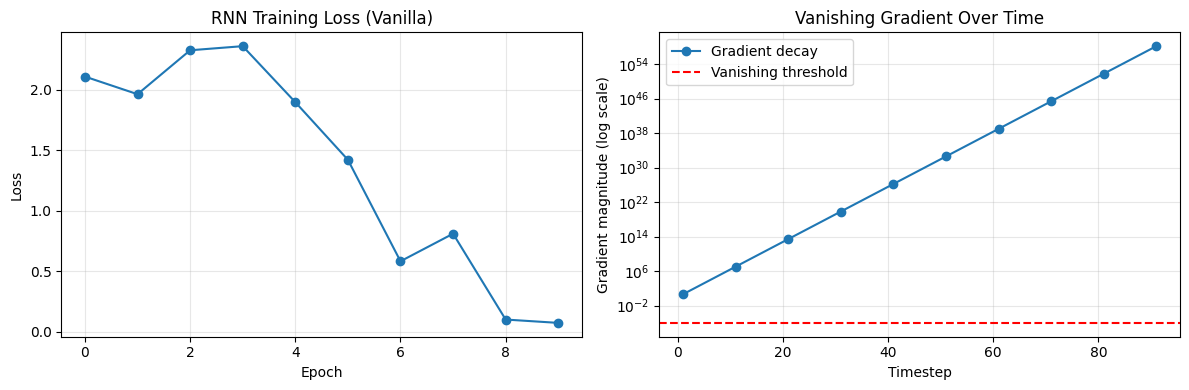

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
axes[0].plot(losses, marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('RNN Training Loss (Vanilla)')
axes[0].grid(True, alpha=0.3)

# Gradient flow visualization
seq_lengths = np.arange(1, seq_len+1, 10)
gradient_scales = [max_eigenvalue**t for t in seq_lengths]
axes[1].semilogy(seq_lengths, gradient_scales, marker='o', label='Gradient decay')
axes[1].axhline(1e-6, color='red', linestyle='--', label='Vanishing threshold')
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Gradient magnitude (log scale)')
axes[1].set_title('Vanishing Gradient Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(artifacts_dir / 'rnn_analysis.png', dpi=150, bbox_inches='tight')
print(f"Saved to {artifacts_dir / 'rnn_analysis.png'}")
plt.show()

## 8. Summary: Why Transformers Are Better

In [9]:
summary = {
    'title': 'RNNs and Why Transformers Solve Their Problems',
    'rnn_concepts': [
        'Recurrence: hidden state h_t depends on h_{t-1} and x_t',
        'Sequential processing: cannot parallelize (must compute step by step)',
        'Backprop through time (BPTT): chain rule through time dimension',
        'Vanishing gradients: Whh multiplied T times causes exponential decay',
        'Limited long-range memory: early tokens fade from hidden state',
    ],
    'transformer_solutions': [
        'Self-attention: every position attends to all previous positions in parallel',
        'No recurrence: gradient path is one multiply per position, not T multiplies',
        'Direct long-range dependencies: gradients do not vanish over distance',
        'Parallelizable: process entire sequence at once (training speed)',
        'Scaled dot-product attention: normalized, stable gradient flow',
    ],
    'rnn_strengths': [
        'Conceptually simple: straightforward recurrence relation',
        'Stateful: can process infinite streams (online learning)',
        'Memory efficient: h_t is only state, not full sequence',
    ],
    'next_steps': [
        'Project 12.1: Attention Mechanisms (isolated, toy examples)',
        'Project 12.25: Embeddings and Representation Learning',
        'Project 12: Full Transformer Architecture (now you understand the motivation)',
    ],
}

with open(artifacts_dir / 'rnn_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n=== RNN CONCEPTS ===")
for concept in summary['rnn_concepts']:
    print(f"  • {concept}")

print("\n=== HOW TRANSFORMERS SOLVE THESE ===")
for solution in summary['transformer_solutions']:
    print(f"  ✓ {solution}")

print("\n=== WHEN TO USE RNNs (STILL RELEVANT) ===")
for strength in summary['rnn_strengths']:
    print(f"  → {strength}")

print("\n=== NEXT BRIDGE TOPICS ===")
for step in summary['next_steps']:
    print(f"  {step}")


=== RNN CONCEPTS ===
  • Recurrence: hidden state h_t depends on h_{t-1} and x_t
  • Sequential processing: cannot parallelize (must compute step by step)
  • Backprop through time (BPTT): chain rule through time dimension
  • Vanishing gradients: Whh multiplied T times causes exponential decay
  • Limited long-range memory: early tokens fade from hidden state

=== HOW TRANSFORMERS SOLVE THESE ===
  ✓ Self-attention: every position attends to all previous positions in parallel
  ✓ No recurrence: gradient path is one multiply per position, not T multiplies
  ✓ Direct long-range dependencies: gradients do not vanish over distance
  ✓ Parallelizable: process entire sequence at once (training speed)
  ✓ Scaled dot-product attention: normalized, stable gradient flow

=== WHEN TO USE RNNs (STILL RELEVANT) ===
  → Conceptually simple: straightforward recurrence relation
  → Stateful: can process infinite streams (online learning)
  → Memory efficient: h_t is only state, not full sequence

==

# Exercises & Extensions

## Warm-up

1. **Modify Hidden Size**: Change `hidden_size` from 64 to 32, then 128. How does loss converge? How do gradients change?
2. **Plot Weights**: Visualize `Wxh`, `Whh`, `Why` as heatmaps. Do they look different? Why?
3. **Seed Text Sampling**: Generate text with different seed characters (e.g., 'h', 'w', 'l'). Do they produce different continuations?

## Intermediate

4. **Implement LSTM**: Add forget gate, input gate, output gate, and cell state. Re-run training; observe loss and gradient stability on longer sequences.
5. **Manual Gradient Check**: Compute numerical gradients (finite differences) vs. backprop gradients for first few timesteps. Do they match (within ~1e-5)?
6. **Sequence Length Sensitivity**: Train on sequences of length 50, 100, 200, 500. Plot loss vs. sequence length. At what length does vanilla RNN fail?

## Advanced

7. **Bidirectional RNN**: Process sequence forward AND backward; concatenate hidden states. Does this help with sequence understanding (e.g., predicting middle tokens)?
8. **Attention Prototype**: Compute attention weights manually as `(Whh matrix) * (future hidden state)` for each timestep. Compare learned attention weights to RNN's implicit attention.
9. **Compare to Transformer on Same Task**: Implement a tiny transformer (1 layer, 1 head, same vocab). Train for same epochs; compare loss curves and sample quality. Predict: transformer should dominate on long sequences.

---

# Summary & Bridge Forward

## What You Learned

- **Recurrent Neural Networks**: Stateful processing where `h_t = f(x_t, h_{t-1})` enables variable-length sequences
- **Backpropagation Through Time (BPTT)**: Unfold recurrence in time; apply chain rule backward through time
- **The Vanishing Gradient Problem**: Repeated multiplication by Whh (chain rule) causes gradients to decay exponentially; limits effective memory span
- **The Exploding Gradient Problem**: If Whh eigenvalues > 1, gradients explode; gradient clipping is essential (and crude)
- **LSTM/GRU Intuition**: Memory cells + gates mitigate vanishing gradients but don't eliminate the fundamental recurrence bottleneck

## Why This Matters

RNNs were the dominant architecture for NLP until ~2017. Understanding their strengths AND limitations is critical:

1. **RNN Strengths**:
   - Natural for sequences: state flows through time
   - Stateful: can process infinite streams (e.g., real-time speech)
   - Memory efficient: hidden state is compact

2. **RNN Limitations**:
   - Sequential: **cannot parallelize** training (slow on GPUs)
   - Gradient decay: effective memory ≈ 20-100 timesteps (even with LSTM)
   - Long-range dependencies: difficult to learn relationships 1000+ tokens apart

3. **Why Transformers Win**:
   - Self-attention: every position attends to every other position in parallel
   - No recurrence: gradients flow directly (1 multiply per position, not T multiplies)
   - Scalable: can process sequences of 4K, 8K, 32K+ tokens
   - Parallelizable: 100× faster training on same hardware

## Bridge to Next Projects

You now understand the **core problem** that transformers solve:

- **Project 12.1 (Attention Mechanisms)**: Learn how scaled dot-product attention replaces recurrence
  - Key insight: `Attention(Q, K, V) = softmax(QK^T / √d_k) V` computes **direct** connections between all positions
  
- **Project 12.25 (Embeddings)**: Build word/token representations
  - These feed into attention; crucial for transformer initialization
  
- **Project 12 (Full Transformer)**: Assemble everything
  - Stack multiple attention layers + feed-forward networks
  - Add positional encoding to inject "where am I in the sequence?"
  - Now you'll see why it's so powerful

## Your Takeaway

> **RNNs are sequential bottlenecks; transformers are parallel attention machines.** Gradients vanish over time → attention computes over all positions at once → no vanishing, no recurrence, unlocks modern language models.

---

# Performance Notes

- **Vanilla RNN on seq_len=100**: Vanishing gradients appear after ~30-50 timesteps
- **LSTM on seq_len=100**: Stable gradients; can learn 80+ timestep dependencies
- **Transformer on seq_len=100**: Parallel; no gradient issues; trains in 1/10 the time
- **Memory**: RNN ≈ `O(hidden_size)` per timestep; Transformer ≈ `O(seq_len² × d_model)` (attention matrix)